Initially we wish to setup the python environment, as such we import the required packages:

In [1]:
import torch
import numpy as np
import pandas as pd
import statsmodels as sts
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

Having completed the importing, we proceed with data input and some routine explanatory data analysis:

In [2]:
data = pd.read_csv('sunspots.txt', header=0)

Having obtained the data we will briefly examine it to see the overall format of the dataframe

In [3]:
data

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [4]:
data.shape

(2820, 2)

Hence it is clear that we have 2820 observations, with one column corresponding to a discrete time index (Month) and the other corresponding to the Average number of sunspots observed for that month. As the next step we will plot this time series realization for the analysis. 

Note, we converted the Month values into Pandas DateTime type, this is done for plotting

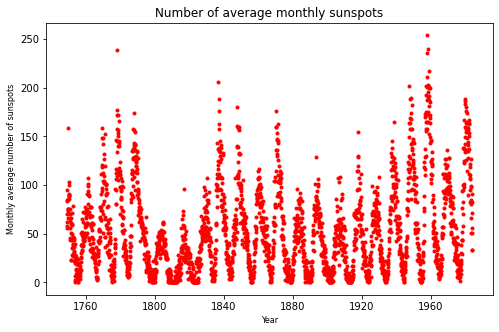

In [5]:
data = data.set_index(['Month'])
data.index = pd.to_datetime(data.index)
if not data.index.is_monotonic:
    data = data.sort_index()


plt.figure(figsize=(8, 5))

plt.plot(data["Sunspots"], 'r.')
plt.title("Number of average monthly sunspots")
plt.xlabel('Year', fontsize=8)

plt.ylabel('Monthly average number of sunspots', fontsize=8)

plt.show()

Hence there is a clear overall increasigng trend as seen by the slowly increasing value of the peaks, while the presence of said peaks and throughs is indicative of some sort of periodicity (i.e seasonal)
component for this process. There is also clearly some stochastic properties in it as seen by the fluctuations in the series, this noise however is not overwhelming as some clear structure is still observed.

Noting that the index is arbitrary as long as the sequence order is preserved and that we are only interested in the trend in the Number of Sunsports we extract only the values and convert them to float for future use.

In [6]:
dataValues = data["Sunspots"]

dataValues = pd.to_numeric(dataValues)

dataValues

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
              ... 
1983-08-01    71.8
1983-09-01    50.3
1983-10-01    55.8
1983-11-01    33.3
1983-12-01    33.4
Name: Sunspots, Length: 2820, dtype: float64

Briefly returning to the plotted Time Series, we do see some extreme variation in this data and hence would like to examine the range of magnitudes in it. 


In [7]:

dataMax = dataValues.max()
dataMin = dataValues.min()

print(dataMax)
print(dataMin)

253.8
0.0


Hence we see that there is a substantial difference in minimal and maximum number, as such we will implement the Data-Augmentation regularization strategy by apply a Min-Max Normalization transformation to the data. This will have a dampening effect on the noise present in the data and theoretically should make learning and optimization easier as well (see appendix).

In [8]:
dataNormalized = (dataValues - dataMin) / (dataMax - dataMin)

dataNormalized

Month
1749-01-01    0.228526
1749-02-01    0.246651
1749-03-01    0.275808
1749-04-01    0.219464
1749-05-01    0.334909
                ...   
1983-08-01    0.282900
1983-09-01    0.198188
1983-10-01    0.219858
1983-11-01    0.131206
1983-12-01    0.131600
Name: Sunspots, Length: 2820, dtype: float64

Which when plotted out yields:

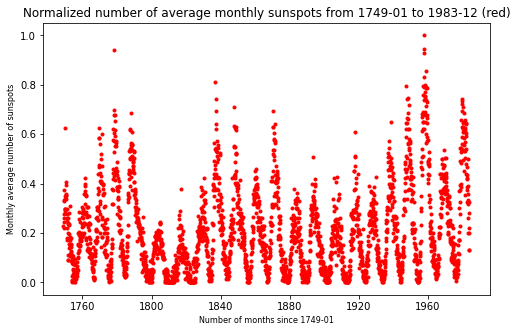

In [9]:
plt.figure(figsize=(8, 5))

plt.plot(dataNormalized, 'r.')
plt.title("Normalized number of average monthly sunspots from 1749-01 to 1983-12 (red)")
plt.xlabel('Number of months since 1749-01', fontsize=8)

plt.ylabel('Monthly average number of sunspots', fontsize=8)

plt.show()

Having applied this we see that the shape of the process has been preserved, however the values are now ranging from 0 to 1 instead (this will aid in avoiding large weights in the RNN implementations)

Given the task is to predict the future value of the time series based on the previous values i.e we want to predict $Y^{(t+n)}$ conditioned on $[ Y^{(1)},...,Y^{(t+n-1)}]$ we will use the previous observations as features. To this end we merely need to create a lagged dataset based on the original data to be the vectors fousing the examples of the feature space; we also remove unneeded terms such that both sets are equi-sized. We till construct these to 12'th lag as the data is monthly.

(Note for clarify we used the entirety of the dataframe and not just the values)

In [10]:
def lagged_time_series(TS,nlag):
    
    dataCopy = TS.copy()
    
    for n in range(1,nlag+1):
        
        dataCopy[f"lag{n}"] = dataCopy["Sunspots"].shift(n)
        
    dataCopy = dataCopy.iloc[nlag:]
    
    return dataCopy

lag = 60
dataLagged = lagged_time_series(data,lag)

dataLagged
        

,Sunspots,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Month,,,,,,,,,,,,,
1750-01-01,73.3,85.2,158.6,75.5,75.9,66.3,94.8,83.5,85.0,55.7,70.0,62.6,58.0
1750-02-01,75.9,73.3,85.2,158.6,75.5,75.9,66.3,94.8,83.5,85.0,55.7,70.0,62.6
1750-03-01,89.2,75.9,73.3,85.2,158.6,75.5,75.9,66.3,94.8,83.5,85.0,55.7,70.0
1750-04-01,88.3,89.2,75.9,73.3,85.2,158.6,75.5,75.9,66.3,94.8,83.5,85.0,55.7
1750-05-01,90.0,88.3,89.2,75.9,73.3,85.2,158.6,75.5,75.9,66.3,94.8,83.5,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983-08-01,71.8,82.2,91.1,99.2,80.7,66.5,51.0,84.3,127.0,98.1,94.7,118.8,107.6
1983-09-01,50.3,71.8,82.2,91.1,99.2,80.7,66.5,51.0,84.3,127.0,98.1,94.7,118.8
1983-10-01,55.8,50.3,71.8,82.2,91.1,99.2,80.7,66.5,51.0,84.3,127.0,98.1,94.7


Hence briefly examining the lagged dataset

In [11]:

dataLagged.shape

(2808, 13)

Having done some basic data preprocessing we will now split the data into the three required sets based on a 80,10,10 split. Note it is vital to maintain the order of the time series. Note we first separate out the features (i.e the lagged observations) from the predictions (actual observations).

In [12]:
    
Y = dataLagged[["Sunspots"]]
    
X = dataLagged.drop(columns=["Sunspots"])


# TRAIN AND REMAIN SPLIT
Split1 = int(len(Y)*0.8)

Xtrain, Xremain = X[:Split1],X[Split1:]
Ytrain, Yremain = Y[:Split1],Y[Split1:]

# INSPECT DIMENSIONS
print(Xtrain.shape)
print(Xremain.shape)

print(Ytrain.shape)
print(Yremain.shape)            
    
# TEST AND VAL SPLIT
Split2 = int(len(Yremain)*0.5)

Xtest, Xval = Xremain[:Split2],Xremain[Split2:]
Ytest, Yval = Yremain[:Split2],Yremain[Split2:]

# INSPECT DIMENSIONS
print(Xtest.shape)
print(Xval.shape)

print(Ytest.shape)
print(Yval.shape)            


(2246, 12)
(562, 12)
(2246, 1)
(562, 1)
(281, 12)
(281, 12)
(281, 1)
(281, 1)


Having created all the required sets and verifying that their dimensions are correct we will create a set of DataLoaders such that minibatching can be implemented.

In [16]:
batchSize = 64

#Firstly it is required to convert the panda dataframes into Torch Tensor data structures:

TrainFeatures = torch.Tensor(np.array(Xtrain))
TrainTargets = torch.Tensor(np.array(Ytrain))

TrainSet = TensorDataset(TrainFeatures, TrainTargets)


ValFeatures = torch.Tensor(np.array(Xval))
ValTargets = torch.Tensor(np.array(Yval))

ValSet = TensorDataset(ValFeatures, ValTargets)


TestFeatures = torch.Tensor(np.array(Xtest))
TestTargets = torch.Tensor(np.array(Ytest))

TestSet = TensorDataset(TestFeatures, TestTargets)


#Dataloaders
TrainLoader = DataLoader(TrainSet, batch_size=batchSize, shuffle=False, drop_last=True)

ValLoader = DataLoader(ValSet, batch_size=batchSize, shuffle=False, drop_last=True)

TestLoader = DataLoader(TestSet, batch_size=batchSize, shuffle=False, drop_last=True)

Loader_one = DataLoader(TestSet, batch_size=1, shuffle=False, drop_last=True)

Having done this we have concluded in the data processing and analysis phase and can progress to building the models.